In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import torch.nn.functional as F
import numpy as np
from lnets.utils.config import process_config
from lnets.utils.saving_and_loading import *
from lnets.data.load_data import load_data

from matplotlib import cm

In [2]:
## Load Lipschitz model
pretrained_root = '/home/jsk/workspace/LNets/outs/classification/finetune/classify_lipschitz-bjorck_mnist_adam_1e-05_classify_fc_linear_bjorck_act_relu_depth_4_width_1024_grouping_2_2019_11_07_18_09_34_154012'
model, model_config = load_model_from_config(pretrained_root)
data = load_data(model_config)

In [3]:
## Load Plain model
baseline_root = '/home/jsk/workspace/LNets/out/classification/mnist/classify_lipschitz-standard_mnist_adam_0.001_classify_fc_linear_standard_act_relu_depth_4_width_1024_grouping_2_2019_11_09_08_58_10_039143'
base_model, base_model_config = load_model_from_config(baseline_root)
data_base = load_data(base_model_config)

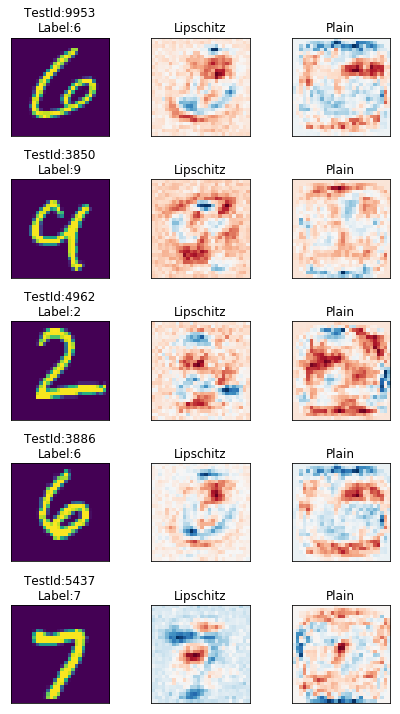

In [4]:
## Visualize some examples with saliency maps from the test set
num_test = len(data['test'].dataset)
num_vis = 5
np.random.seed(1)
testids = np.random.choice(num_test, num_vis, replace=False)

f, axes = plt.subplots(num_vis, 3, figsize=(6, 2 * num_vis))

for i, idx in enumerate(testids):
    # For the Lipschitz function
    x, y = data['test'].dataset[idx]
    x.requires_grad = True
    out = model(x).squeeze()
    out[y.data].backward()
    sal = x.grad.data[0]

    # For plain function
    x, y = data['test'].dataset[idx]
    x.requires_grad = True
    out = base_model(x).squeeze()
    out[y.data].backward()
    sal_base = x.grad.data[0]

    axes[i,0].imshow(x.detach().numpy()[0])
    axes[i,1].imshow(sal, cmap=cm.RdBu)
    axes[i,2].imshow(sal_base, cmap=cm.RdBu)
    axes[i,0].set_xticks(())
    axes[i,0].set_yticks(())
    axes[i,1].set_xticks(())
    axes[i,1].set_yticks(())
    axes[i,2].set_xticks(())
    axes[i,2].set_yticks(())
    axes[i,0].set_title('TestId:%d\nLabel:%d'%(idx, y.data))
    axes[i,1].set_title('Lipschitz')
    axes[i,2].set_title('Plain')

    plt.tight_layout()

In [46]:
## Define the performance degradation experiment module

def manipulate_input(x, idxs, replace='zero'):
    if replace == 'zero':
        # replace the pixels to be zero
        # print(idxs)
        x[:, idxs[0], idxs[1]] = 0
    else:
        # TODO other methods of replacing the pixel values?
        raise NotImplementedError
    return x

def auc_degradation_measure(model, x, y, sal, axes=None, plot=False):
    # Compute the auc measure for prediction score degredation.
    if x.grad is not None:
        x.requires_grad = False
    
    # Order the saliency values (descending order)
    sal_flat = sal.flatten()
    r, c = sal.shape
    order = np.argsort(sal_flat)
    row_idx = order // r
    col_idx = order % r
    row_idx = row_idx.numpy()[::-1]
    col_idx = col_idx.numpy()[::-1]
    
    # Make this faster using vector inputs
    # Feed in D x row x col input to the model
    # and work on matrix format
    x_all = x
    for i, j in zip(row_idx, col_idx):
        x = manipulate_input(x, (i,j))
        x_all = torch.cat((x_all, x), 0)
    prob_vals = F.softmax(model(x_all).squeeze())[:, y]
    prob_vals = prob_vals.detach().numpy()
    auc = np.sum(prob_vals)
    
    if plot:
        if axes is None:
            f, axes = plt.subplots(1,1)
        axes.plot(range(len(prob_vals)), prob_vals)
        axes.set_xlabel('Removing Pixels in Order')
        axes.set_ylabel('Prediction Score')
        axes.set_title('AUC:%0.3f'%auc)
    return axes, auc, prob_vals
    

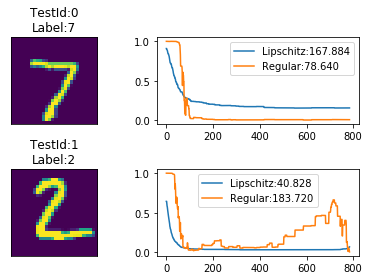

In [51]:
## Visualize degradation comparisons for Lipschitz vs Plain network on test data
num_test = len(data['test'].dataset)
num_vis = 2
np.random.seed(1)
testids = np.random.choice(num_test, num_vis, replace=False)
testids = [0,1]

f, axes = plt.subplots(num_vis, 2, figsize=(6, 2 * num_vis))

for i, idx in enumerate(testids):
    # Plot data
    x, y = data['test'].dataset[idx]
    axes[i,0].imshow(x.detach().numpy()[0])    
    axes[i,0].set_xticks(())
    axes[i,0].set_yticks(())
    axes[i,0].set_title('TestId:%d\nLabel:%d'%(idx, y.data))
    
    # For the Lipschitz function
    x, y = data['test'].dataset[idx]
    x.requires_grad = True
    out = model(x).squeeze()
    out[y.data].backward()
    sal = x.grad.data[0]
    _, auc_l, pvals_l = auc_degradation_measure(model, x, y, sal, axes=None)

    # For plain function
    x, y = data['test'].dataset[idx]
    x.requires_grad = True
    out = base_model(x).squeeze()
    out[y.data].backward()
    sal_base = x.grad.data[0]
    _, auc_b, pvals_b = auc_degradation_measure(base_model, x, y, sal, axes=None)
    
    axes[i, 1].plot(range(len(pvals_l)), pvals_l, label='Lipschitz:%0.3f'%auc_l)
    axes[i, 1].plot(range(len(pvals_b)), pvals_b, label='Regular:%0.3f'%auc_b)
    axes[i, 1].legend()
    plt.tight_layout()
    
    del x

In [ ]:
## Find out the average AUC value for the entire dataset (computationally heavy)
